In [36]:
import sqlite3 as sql
import csv
import os
from pathlib import Path
from collections import defaultdict

import pandas as pd
from tqdm import tnrange

In [5]:
REPO = (Path(_dh[-1]) / "..").resolve()
DATA = REPO / 'data'

# Map `chembl_targets` to `UniprotID`.

This file is generated with the `kinase-in-chembl` notebooks. Update it if you think there might be more ChEMBL targets.

In [71]:
kinases = pd.read_csv(DATA / "human_kinases_and_chembl_targets.chembl_27.csv")
kinases

,xName,Manning Name,HGNC Name,Kinase Name,Group,Family,SubFamily,UniprotID,chembl_targets,type
0,ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,NaN,P00519,CHEMBL1862,SINGLE PROTEIN
1,ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,NaN,P00519,CHEMBL2096618,CHIMERIC PROTEIN
2,ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,NaN,P00519,CHEMBL2111414,PROTEIN FAMILY
3,ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,NaN,P00519,CHEMBL4296119,PROTEIN-PROTEIN INTERACTION
4,ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,NaN,P00519,CHEMBL4296120,PROTEIN-PROTEIN INTERACTION
...,...,...,...,...,...,...,...,...,...,...
865,BCR,BCR,BCR,Breakpoint cluster region protein,Atypical,BCR,NaN,P11274,CHEMBL4296120,PROTEIN-PROTEIN INTERACTION
866,BCR,BCR,BCR,Breakpoint cluster region protein,Atypical,BCR,NaN,P11274,CHEMBL4296137,PROTEIN-PROTEIN INTERACTION
867,Col4A3BP,Col4A3BP,COL4A3BP,Collagen type IV alpha-3-binding protein,Atypical,Col4A3BP,NaN,Q9Y5P4,CHEMBL3399913,SINGLE PROTEIN
868,BAZ1A,BAZ1A,BAZ1A,Bromodomain adjacent to zinc finger domain pro...,Atypical,BAZ,NaN,Q9NRL2,CHEMBL4105737,SINGLE PROTEIN


We are only interested in `SINGLE PROTEIN` targets for now.

In [72]:
df = kinases[kinases.type == "SINGLE PROTEIN"].drop("type", axis=1)
df

,xName,Manning Name,HGNC Name,Kinase Name,Group,Family,SubFamily,UniprotID,chembl_targets
0,ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,NaN,P00519,CHEMBL1862
8,ACK,ACK,TNK2,Activated CDC42 kinase 1,TK,Ack,NaN,Q07912,CHEMBL4599
9,ACTR2,ACTR2,ACVR2A,Activin receptor type-2A,TKL,STKR,STKR2,P27037,CHEMBL5616
10,ACTR2B,ACTR2B,ACVR2B,Activin receptor type-2B,TKL,STKR,STKR2,Q13705,CHEMBL5466
11,ADCK4,ADCK4,ADCK4,Uncharacterized aarF domain-containing protein...,Atypical,ABC1,ABC1-A,Q96D53,CHEMBL5753
...,...,...,...,...,...,...,...,...,...
861,TAF1L,TAF1L,TAF1L,Transcription initiation factor TFIID subunit ...,Atypical,TAF1,NaN,Q8IZX4,CHEMBL3108641
862,BCR,BCR,BCR,Breakpoint cluster region protein,Atypical,BCR,NaN,P11274,CHEMBL5146
867,Col4A3BP,Col4A3BP,COL4A3BP,Collagen type IV alpha-3-binding protein,Atypical,Col4A3BP,NaN,Q9Y5P4,CHEMBL3399913
868,BAZ1A,BAZ1A,BAZ1A,Bromodomain adjacent to zinc finger domain pro...,Atypical,BAZ,NaN,Q9NRL2,CHEMBL4105737


We will need this dictionary to map between chembl target and uniprot later, when we write the query results to disk.

In [56]:
chembl_to_uniprot = defaultdict(list)
for row in df.itertuples():
    chembl_to_uniprot[row[-1]].append(row[-2])

In [57]:
chembl_to_uniprot

defaultdict(list,
            {'CHEMBL1862': ['P00519'],
             'CHEMBL4599': ['Q07912'],
             'CHEMBL5616': ['P27037'],
             'CHEMBL5466': ['Q13705'],
             'CHEMBL5753': ['Q96D53'],
             'CHEMBL4574': ['Q8IWQ3'],
             'CHEMBL5639': ['Q9Y3S1'],
             'CHEMBL4282': ['P31749'],
             'CHEMBL2431': ['P31751'],
             'CHEMBL4816': ['Q9Y243'],
             'CHEMBL5258': ['Q96NX5'],
             'CHEMBL4247': ['Q9UM73'],
             'CHEMBL5311': ['P37023'],
             'CHEMBL5903': ['Q04771'],
             'CHEMBL5275': ['P36894'],
             'CHEMBL5310': ['P36896'],
             'CHEMBL4439': ['P36897'],
             'CHEMBL5476': ['O00238'],
             'CHEMBL4045': ['Q13131'],
             'CHEMBL2116': ['P54646'],
             'CHEMBL1988': ['P16066'],
             'CHEMBL1169596': ['P10398'],
             'CHEMBL4014': ['P42684'],
             'CHEMBL3797': ['Q13315'],
             'CHEMBL5024': ['Q13535'],
    

# Query local ChEMBL DB for speed

Get your local copy from http://doi.org/10.6019/CHEMBL.database.27. You need `chembl_27_sqlite.tar.gz` for this notebook. Extract it and point `DATABASE` below to the `chembl_27.db` file.

In [73]:
DATABASE = "chembl_27/chembl_27_sqlite/chembl_27.db"

In [59]:
conn = sql.connect(DATABASE, isolation_level=None)
db = conn.cursor()

Check which kind of assays can be found on human kinases.

In [60]:
q = f"""
SELECT standard_type, COUNT(standard_type) 
FROM activities
    LEFT JOIN assays ON assays.assay_id=activities.assay_id
    LEFT JOIN target_dictionary ON target_dictionary.tid=assays.tid
WHERE
    target_dictionary.chembl_id IN ({', '.join([f'"{x}"' for x in set(df.chembl_targets.tolist())])})
GROUP BY standard_type 
ORDER BY 2 DESC
"""
assay_types = pd.DataFrame.from_records(db.execute(q), columns=["Value", "Count"])
assay_types

,Value,Count
0,Inhibition,234880
1,IC50,227471
2,Ki,135270
3,Residual Activity,70152
4,Kd apparent,51695
...,...,...
118,TC50,1
119,fIC50,1
120,kmax,1
121,kmax/KS,1


In [61]:
assay_types[:10]

,Value,Count
0,Inhibition,234880
1,IC50,227471
2,Ki,135270
3,Residual Activity,70152
4,Kd apparent,51695
5,Kd,50709
6,Potency,49389
7,Activity,34245
8,Thermal melting change,9360
9,EC50,3744


There's a lot of information we are not using! `Inhibition` is as populated as `IC50`, but we don't know what kind of information this category contains.

Get all entries in the SQL db that:

- Correspond to IC50 or Ki measurements. Check `activities.standard_type` fields.
- assay_type = B (Binding)
- Relation = '='
- Target is part of the human kinome
- Confidence score is greather than zero (in practice, only 43 entries have score=0; the rest are either 8 or 9)

Then:
- Write Activity ID, Target ID, Publication Year and ID, Type of assay, measurement and units, canonical SMILES and Confidence scores to CSV
- Plot confidence value populations

Try:
- Cluster measurements by `doc_id` to homogeneize data (DOI is only available for ~100 000 entries, but doc_id is present in all rows would serve the same purpose, I guess!)

Note that querying for `docs.year` discards ~1000 entries because that field might not be available in those rows and the SELECT query gets dropped.

In [62]:
q = f"""
SELECT
    activities.activity_id, target_dictionary.chembl_id, 
    activities.standard_type, activities.standard_value, activities.standard_units, 
    compound_structures.canonical_smiles,
    component_sequences.sequence,
    assays.confidence_score, docs.doc_id, docs.year
FROM 
    activities
    LEFT JOIN assays ON assays.assay_id=activities.assay_id
    LEFT JOIN target_dictionary ON target_dictionary.tid=assays.tid
    LEFT JOIN compound_structures ON activities.molregno=compound_structures.molregno
    LEFT JOIN docs ON docs.doc_id=activities.doc_id
    LEFT JOIN target_components ON target_dictionary.tid=target_components.tid
    LEFT JOIN component_sequences ON target_components.component_id=component_sequences.component_id
WHERE
    target_dictionary.chembl_id IN ({', '.join([f'"{x}"' for x in set(df.chembl_targets.tolist())])})
AND
    activities.standard_relation="="
AND
    assays.assay_type="B"
AND
    activities.standard_type in ("IC50", "Ki", "Kd")
AND
    assays.confidence_score > 0
"""
result = db.execute(q)

In [63]:
with open('activities-chembl27.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["activities.activity_id", "target_dictionary.chembl_id", 
                     "activities.standard_type", "activities.standard_value", "activities.standard_units", 
                     "compound_structures.canonical_smiles", 
                     "component_sequences.sequence",
                     "assays.confidence_score", "docs.doc_id", "docs.year", 
                     "UniprotID"])
    for row in result:  # iterate over the query result to avoid loading everything in memory
        writer.writerow(row + ("-".join(chembl_to_uniprot[row[1]]),))

In [64]:
activities = pd.read_csv("activities-chembl27.csv")
activities

,activities.activity_id,target_dictionary.chembl_id,activities.standard_type,activities.standard_value,activities.standard_units,compound_structures.canonical_smiles,component_sequences.sequence,assays.confidence_score,docs.doc_id,docs.year,UniprotID
0,32260,CHEMBL203,IC50,41.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,8,4959,2002.0,P00533
1,32262,CHEMBL279,IC50,16500.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,MQSKVLLAVALWLCVETRAASVGLPSVSLDLPRLSIQKDILTIKAN...,8,4959,2002.0,P35968
2,32267,CHEMBL203,IC50,170.0,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,8,4959,2002.0,P00533
3,32330,CHEMBL258,IC50,140.0,nM,Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1,MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRD...,9,3891,2000.0,P06239
4,32331,CHEMBL258,IC50,1180.0,nM,Nc1ncnc2c1c(-c1cccc(Oc3ccccc3)c1)cn2C1CCCC1,MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRD...,9,3891,2000.0,P06239
...,...,...,...,...,...,...,...,...,...,...,...
203939,18813164,CHEMBL2842,Ki,42.0,nM,Nc1cc(C(F)F)c(-c2nc(N3CCOCC3)cc(N3CCOCC3)n2)cn1,MLGTGPAAATTAATTSSNVSVLQQFASGLKSRNEETRAKAAKELQH...,9,110134,2018.0,P42345
203940,18813165,CHEMBL2842,Ki,30.0,nM,Nc1cc(C(F)(F)F)c(-c2cc(N3C4CCC3COC4)nc(N3C4CCC...,MLGTGPAAATTAATTSSNVSVLQQFASGLKSRNEETRAKAAKELQH...,9,110134,2018.0,P42345
203941,18813166,CHEMBL2842,Ki,12.0,nM,Nc1cc(C(F)F)c(-c2cc(N3C4CCC3COC4)nc(N3C4CCC3CO...,MLGTGPAAATTAATTSSNVSVLQQFASGLKSRNEETRAKAAKELQH...,9,110134,2018.0,P42345
203942,18813167,CHEMBL2842,Ki,435.0,nM,Nc1cc(C(F)(F)F)c(-c2nc(N3C4CCC3COC4)cc(N3C4CCC...,MLGTGPAAATTAATTSSNVSVLQQFASGLKSRNEETRAKAAKELQH...,9,110134,2018.0,P42345


In [68]:
counts = activities["assays.confidence_score"].value_counts()
counts

9    113546
8     90398
Name: assays.confidence_score, dtype: int64

59286     9202
102255    5247
48311     2951
102826    1518
94296     1511
52612     1391
103090    1305
94711     1176
52618     1060
94085     1030
Name: docs.doc_id, dtype: int64

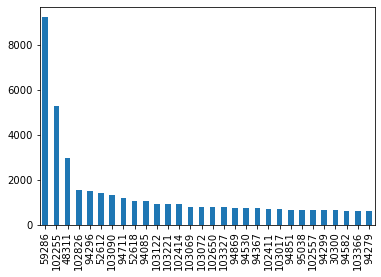

In [69]:
doc_counts = activities["docs.doc_id"].value_counts()
display(doc_counts[:10])
doc_counts[:30].plot.bar()

In [70]:
total_available_measurements = (
      assay_types[assay_types['Value']=='Ki']['Count'].values[0] 
    + assay_types[assay_types['Value']=='IC50']['Count'].values[0] 
    + assay_types[assay_types['Value']=='Kd']['Count'].values[0]
)
print(f'Recovered {(100*(counts[9] + counts[8])/total_available_measurements):.2f}% ({counts[9] + counts[8]} out of {total_available_measurements})')

Recovered 49.33% (203944 out of 413450)
